In [1]:
# imports
import datetime
import numpy as np
import pandas as pd
import os
from os import listdir
from datetime import date
import matplotlib.pyplot as plt
from os.path import isfile, join

In [13]:
# Toplevel log file directories
gsi_log_dir = "/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs"
troxel_log_dir = "/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing"
troxel_master = "/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/TAMU_112419_Gemini.csv"

In [3]:
# choose experiment dirs

# RUN!
gsi_exp_dir = os.path.join( gsi_log_dir, "RUN1_ARGON_LET6.7_" )
troxel_exp_dir = os.path.join( troxel_log_dir, "Run_1")
fname = "Run 1"

# RUN2
#gsi_exp_dir = os.path.join( gsi_log_dir, "RUN2_LET6.7" )
#troxel_exp_dir = os.path.join( troxel_log_dir, "Run_2")

# RUN3
#gsi_exp_dir = os.path.join( gsi_log_dir, "RUN3_LET6.7" )
#troxel_exp_dir = os.path.join( troxel_log_dir, "Run_3")

# RUN18
#gsi_exp_dir = os.path.join( gsi_log_dir, "RUN18_LET60" )
#troxel_exp_dir = os.path.join( troxel_log_dir, "Run_18")
#fname = "Run 18"

# RUN20
gsi_exp_dir = os.path.join( gsi_log_dir, "RUN19_FUNCTIONALCHECK" )
troxel_exp_dir = os.path.join( troxel_log_dir, "Run_19")
fname = "Run 19"

def get_exp_dirs( gsi_log_dir, troxel_log_dir):
    
    all_dirs = []
    gsi_exp_dirs = [ "RUN1_ARGON_LET6.7_", "RUN2_LET6.7", "RUN3_LET6.7", "RUN4_LET6.7", \
                    "RUN5_LET6.7", "RUN6_LET6.7", "RUN7_LET6.7", "RUN8_LET17", \
                    "RUN9_FUNCTIONALCHECK", "RUN10_LET26.6", "RUN11_LET26.6", \
                    "RUN12_LET37", "RUN13_FUNCTIONALCHECK", "RUN14_LET37_TEMP80", \
                    "RUN15_FUNCTIONALCHECK", "RUN16_LET53.4", "RUN17_FUNCTIONALCHECK", \
                    "RUN18_LET60", "RUN19_FUNCTIONALCHECK" ]
    for i in range(19):
        gsi_exp_dir = os.path.join( gsi_log_dir, gsi_exp_dirs[i] )
        troxel_exp_dir = os.path.join( troxel_log_dir, "Run_%d" % (i+1)  )
        fname = "Run %d" % ( i + 1 )
        all_dirs.append( ( gsi_exp_dir, troxel_exp_dir, fname ) )
    
    return all_dirs
    
all_dirs = get_exp_dirs( gsi_log_dir, troxel_log_dir )
       

In [4]:
# locate search logging file
def get_search_log_df(gsi_exp_dir):
    files = [f for f in listdir(gsi_exp_dir) if isfile(join(gsi_exp_dir, f))]
    for i in range(len(files)):
        if files[i][0:6] == 'SEARCH':
            file = files[i]
            break
    file = gsi_exp_dir + '/' + file
    with open(file) as f:
        content = f.readlines()
    content = [x.strip() for x in content] 

    # get time data
    for i in range(len(content)):
        if content[i][0:4] == '2019':
            content = content[i:]
            break
        
    # break time-stamped data into a multi-dimensional array        
    search = []        
    for i in range(len(content)):
        temp = content[i].split()
        try:
            date_time_str = temp[0] + ' ' + temp[1]
            date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')
        except:
            print("ERROR PARSING LINE IN FILE", temp)
            break
        date = date_time_obj.date()
        time = date_time_obj.time()
        col3 = ''
        for i in range(len(temp[2:])):
            col3 = col3 + temp[i+2] + ' '
        col3 = col3[:-1]
        item = [date_time_obj, date, time, col3]
        search.append(item)

    # create pandas dataframe with time-stamped data
    df = pd.DataFrame(search) 
    #df.head(10)
    return df

all_dfs = []
for i in range(len(all_dirs)):
    gsi_exp_dir = all_dirs[i][0]
    print(gsi_exp_dir)
    df = get_search_log_df( gsi_exp_dir )
    all_dfs.append(df)
    
print(len(all_dfs))

/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN1_ARGON_LET6.7_
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN2_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN3_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN4_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN5_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN6_LET6.7
ERROR PARSING LINE IN FILE ['terminate', 'arc']
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN7_LET6.7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN8_LET17
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs/RUN9_FUNCTIONALCHECK
ERROR PARSING LINE IN FILE ['\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [5]:
# Get duration and num data points...

def get_search_dur( df ):
    times = df[2].tolist()
    def get_time(beginning, end):
        t = datetime.datetime.combine(date.min, end) - datetime.datetime.combine(date.min, beginning)
        return t

    t_seconds = []
    for i in range(len(times)):
        t_seconds.append(get_time(times[0],times[i]))
        t_seconds[i] = t_seconds[i].total_seconds()
    
    t_max = round(max(t_seconds), 2)
    print('log file duration: ' + str(t_max) + ' seconds')

    logs = df[3].tolist()
    logs = [logs[i][:20] for i in range(len(logs))]

    print(str(len(logs)) + ' data points recorded!')
    
#get_search_dur( df )

In [6]:
# plot search logs
#%matplotlib notebook
#import matplotlib.pyplot as plt
#import numpy as np

#lim = len(t_seconds)
#mult = 5
#Max = t_seconds[len(t_seconds)-1]
#interval = Max/10 + 10 - (Max/10)%10

#def addtext(i,time, log, ax, props):
#    if i%2 == 0:
#        ax.text(time, 0.1, log, props, rotation=45)
#    else:
#        ax.text(time, 0.5, log, props, rotation=45)
#    ax.grid(False)

#fig, ax = plt.subplots() #figsize=(20,5))

#for i in range(lim):
#    addtext(i,t_seconds[i], logs[i], ax, {'ha': 'left', 'va': 'bottom'})

#ax.set_xticks(np.arange(0, Max, interval), [])
#ax.set_xlabel('Time (seconds)')

## begone the right, left, top and bottom spines
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
#plt.yticks([], [])
#ax.set_yticklabels([])
#plt.title('Event Logs by Time')
#f = plt.show

In [7]:
# Parse the power log file

def get_power_df( troxel_exp_dir ):
    troxel_test_file = os.path.join( troxel_exp_dir, '2 E36313A 192.168.10.10.CSV' )
    try:
        troxel_data = pd.read_csv(troxel_test_file) 
    except:
        print("Could not parse", troxel_test_file)
        return None
    troxel_data = troxel_data.iloc[8:]
    troxel_data.rename(columns={"Address": "Time (s)", "TCPIP0::192.168.10.10::5025::SOCKET": "I2 (DC Current)", "Unnamed: 2": "V2 (DC Volt)"}, inplace = True)
    troxel_data.head(10)
    return troxel_data


all_troxel_data = []
for i in range(len(all_dirs)):
    troxel_exp_dir = all_dirs[i][1]
    print(troxel_exp_dir)
    troxel_data = get_power_df( troxel_exp_dir )
    all_troxel_data.append( troxel_data )
    

/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_1
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_2
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_3
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_4
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_5
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_6
Could not parse /Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_6/2 E36313A 192.168.10.10.CSV
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_7
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_8
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_9
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_10
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_11
/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_12
/Users/gwilliams/

In [8]:
# Parse the beam log file

def get_beam_df( troxel_exp_dir ):
    rf = open( os.path.join( troxel_exp_dir, '1 34972A 192.168.9.72.CSV' ) )
    lines = rf.readlines()
    rf.close()

    wf = open("/tmp/log.txt","w")

    found = False
    for ln in lines:
        if not found:
            if ln.startswith("Scan Sweep"):
                #print(found)
                found=True
            else:
                continue
            wf.write(ln)
        else:
            wf.write(ln)
    wf.close()

    troxel_data2 = pd.read_csv( "/tmp/log.txt")
    #troxel_data2 = troxel_data2.iloc[8:]
    #troxel_data.rename(columns={"Address": "Time (s)", "TCPIP0::192.168.10.10::5025::SOCKET": "I2 (DC Current)", "Unnamed: 2": "V2 (DC Volt)"}, inplace = True)
    troxel_data2.head(10)
    return troxel_data2

all_troxel_data2 = []
for i in range( len(all_dirs ) ):
    troxel_exp_dir = all_dirs[i][1]
    try:
        troxel_data2 = get_beam_df( troxel_exp_dir )
        all_troxel_data2.append( troxel_data2 )
    except:
        print("Could not get df for ", troxel_exp_dir, i)
        all_troxel_data2.append(None)
        
print( len(all_troxel_data2 ))

Could not get df for  /Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_6 5
Could not get df for  /Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing/Run_13 12
19


In [9]:
# match time stamps across experiments and produce a ts diff

def get_gsi_troxel_diff():
    gsi_pc_ts = "Sun Nov 24 17:56:19 IST 2019"
    troxel_ts = "2019-11-24 09:56:24.037937"

    troxel_time_obj = datetime.datetime.strptime(troxel_ts, '%Y-%m-%d %H:%M:%S.%f')

    # re-orient fields in gsi ts
    parts = gsi_pc_ts.split()
    #print(parts)
    #day = ["Sun","Mon","Tue","Wed","Thurs","Fri","Sat"].indexof(parts[0])
    month = [ "none", "Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec" ].index( parts[1])
    new_ts = "%s-%s-%s %s" % ( parts[-1], month, parts[2], parts[3] )
    #print(new_ts)

    gsi_time_obj = datetime.datetime.strptime(new_ts, '%Y-%m-%d %H:%M:%S')

    diff_time = gsi_time_obj - troxel_time_obj
    #print(diff_time)
    return diff_time

diff_time = get_gsi_troxel_diff()

In [10]:
# adjust all logs relative to GSI time...

def adjust_ts(df, troxel_data, troxel_data2):
    # adjust the board voltage and current time
    #print(troxel_data.columns)
    orig_date_col = troxel_data["Time (s)"]
    #print(type(orig_date_col))
    shape = orig_date_col.shape
    #print(shape[0])
    ts = []
    dt_list = list( orig_date_col )
    #dt_list[0]
    for i in range(shape[0]):
        dtobj = datetime.datetime.strptime( dt_list[i], '%Y-%m-%d %H:%M:%S.%f')
        dtobj = dtobj + diff_time
        ts.append(dtobj)
    #print(ts)
    troxel_data["newts"] = ts
    troxel_data.head(10)
    #print(troxel_data.columns)

    # adjust the beam voltage time

    #print(troxel_data2.columns)
    orig_date_col = troxel_data2["102Time (Sec)"]
    #print(type(orig_date_col))
    shape = orig_date_col.shape
    #print(shape[0])
    ts = []
    dt_list = list( orig_date_col )
    #dt_list[0]
    for i in range(shape[0]):
        dtobj = datetime.datetime.strptime( dt_list[i], '%Y-%m-%d %H:%M:%S.%f')
        dtobj = dtobj + diff_time
        ts.append(dtobj)
    #print(ts)
    troxel_data2["boardvoltage_newts"] = ts
    #troxel_data2.head(10)

    # adjust the temperature time

    #print(troxel_data2.columns)
    orig_date_col = troxel_data2["101Time (Sec)"]
    #print(type(orig_date_col))
    shape = orig_date_col.shape
    #print(shape[0])
    ts = []
    dt_list = list( orig_date_col )
    #dt_list[0]
    for i in range(shape[0]):
        dtobj = datetime.datetime.strptime( dt_list[i], '%Y-%m-%d %H:%M:%S.%f')
        dtobj = dtobj + diff_time
        ts.append(dtobj)
    #print(ts)
    troxel_data2["temp_newts"] = ts
    #troxel_data2.head(10)

for i in range(len(all_dirs)):
    try:
        df = all_dfs[i];
        troxel_data = all_troxel_data[i]
        troxel_data2 = all_troxel_data2[i]
        adjust_ts( df, troxel_data, troxel_data2 )
    except:
        print("Could not adjust ts for ", i)

Could not adjust ts for  5
Could not adjust ts for  12


In [11]:
# plot search logs
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


def prep_plot_data(df, troxel_data, troxel_data2):
    gsi_ts = list(df[0])
    #print(type(gsi_ts[0]),gsi_ts[0], len(gsi_ts))

    logs = list(df[3])
    #print( type(logs[0]), logs[0], len(logs))

    logs_marker = [ ]
    for log in logs:
        if log.find("knn_hamming")>=0:
            logs_marker.append(0)
        elif log.find("duration")>=0:
            logs_marker.append(1)
    #    elif log.find("gnl")>=0:
    #        print("log==",log)
    #        logs_marker.append("-1")
        else:
            #print("log==",log)
            logs_marker.append(-1)

    #print(troxel_data.columns)
    troxel_ts = list(troxel_data["newts"])
    #print( type(troxel_ts[0]), troxel_ts[0], len(troxel_ts))

    voltages = list(troxel_data["V2 (DC Volt)"])
    #print( type(voltages[0]), voltages[0], len(voltages))
    voltages = [ float(v) for v in voltages ]

    current = list(troxel_data["I2 (DC Current)"])
    current = [ float(c) for c in current ]
    #print( type(current[0]), current[0], len(current))

    troxel_beamvoltage_ts = list(troxel_data2["boardvoltage_newts"])
    beam_voltages = list( troxel_data2["102 (Vdc)"] )
    beam_voltages = [ float(v) for v in beam_voltages ]
    #print( type(beam_voltages), beam_voltages[0], len(beam_voltages))

    troxel_temp_ts = list(troxel_data2["temp_newts"])
    temps = list( troxel_data2["101 (°C)"] )
    temps = [ float(v) for v in temps ]
    #print( type(temps), temps[0], len(temps), len(troxel_temp_ts))
    
    return gsi_ts, logs, logs_marker, troxel_ts, voltages, current, troxel_beamvoltage_ts, beam_voltages, troxel_temp_ts, temps

all_gsi_ts = []
all_logs = []
all_logs_marker = []
all_troxel_ts = []
all_voltages = []
all_current = []
all_troxel_beamvoltages_ts = []
all_beam_voltages = []
all_troxel_temp_ts = []
all_temps = []


for i in range(len(all_dirs)):
    
    try:
        gsi_ts, logs, logs_marker, troxel_ts, voltages, \
        current, troxel_beamvoltages_ts, beam_voltages, \
        troxel_temp_ts, temps = \
            prep_plot_data( all_dfs[i], all_troxel_data[i], all_troxel_data2[i] )

        all_gsi_ts.append( gsi_ts )
        all_logs.append( logs )
        all_logs_marker.append( logs_marker )
        all_troxel_ts.append( troxel_ts )
        all_voltages.append( voltages )
        all_current.append( current )
        all_troxel_beamvoltages_ts.append( troxel_beamvoltages_ts )
        all_beam_voltages.append( beam_voltages )
        all_troxel_temp_ts.append( troxel_temp_ts)
        all_temps.append( temps )
    except:
        print("Could not get plot data for", i)
        all_gsi_ts.append( None)
        all_logs.append( None )
        all_logs_marker.append( None )
        all_troxel_ts.append( None )
        all_voltages.append( None )
        all_current.append( None )
        all_troxel_beamvoltages_ts.append( None )
        all_beam_voltages.append( None )
        all_troxel_temp_ts.append( None)
        all_temps.append( None )


Could not get plot data for 5
Could not get plot data for 12


In [82]:
# Load the master Run file
import math
f = open(troxel_master)
lines = f.readlines()
f.close()

f = open("/tmp/test.txt","w")
for ln in lines[1:]:
    f.write(ln)
f.flush()
f.close()

master_df = troxel_data = pd.read_csv("/tmp/test.txt") 
#master_df.head(2)
print( master_df.columns )

expdetails = {}
expnotes = {}
for i in range(len(all_dirs)):
    rows = master_df.loc[master_df['Run number'] == (i+1)]
    #print(rows.shape)
    if (rows.shape[0]==1):
        selbeam = list(rows['Selected beam'])[0]
        print("-%s-"%selbeam)
        if not selbeam:
            continue
        avgflux = list(rows["Average flux (ions/(cm2s))"])[0]
        efflet = list(rows["Effective LET (MeVcm2/mg)"])[0]
        benergy = list(rows["Beam energy (MeV/amu)"])[0]
        notes = list(rows["Run Notes"])[0]
        
        if notes=="nan": 
            notes = "None"
        elif type(notes)==type(1.0) and math.isnan( notes):
            notes = "None"
            
        print("notes=",notes,type(notes))
            
        #targetmat = listrows["Target material"]
        #print(selbeam, avgflux,efflet,benergy,"")
        expdet = "beam=%s / avg flux=%s / eff LET=%s / beam E=%s" % (selbeam, avgflux,efflet, benergy)
        print(i+1, expdet)
        expdetails[i+1]=expdet
        expnotes[i+1]=notes

Index(['Run number', 'Run file name', 'Run start date and time',
       'Run end date and time', 'Duration of the run', 'Number of events',
       'Selected beam', 'Al degrader thickness (mil)',
       'Number of layers (layer file name)', 'Beam energy (MeV/amu)',
       'Beam energy (MeV)', 'Target material', 'Nominal LET (MeVcm2/mg)',
       'Nominal range (um)', 'Effective LET (MeVcm2/mg)',
       'Effective range (um)', 'DUT location', 'Position set name',
       'Effective fluence (ions/cm2)', 'Dose (rad)', 'Live time (s)',
       'Dead time (s)', 'Average flux (ions/(cm2s))', 'Average flux error (%)',
       'Overall uniformity (%)', 'Overall central shift (%)',
       'Calibration factor', 'DUT X coordinate', 'DUT Y coordinate',
       'DUT Z coordinate', 'DUT tilt angle', 'Roll angle', 'Unused coordinate',
       'Selected Al degrader number', 'Degrader rotation angle',
       'Detector bias (V)', 'Facility', 'Beam Operator', 'Test Engineers',
       'DUT Manufacturer', 'Manufa

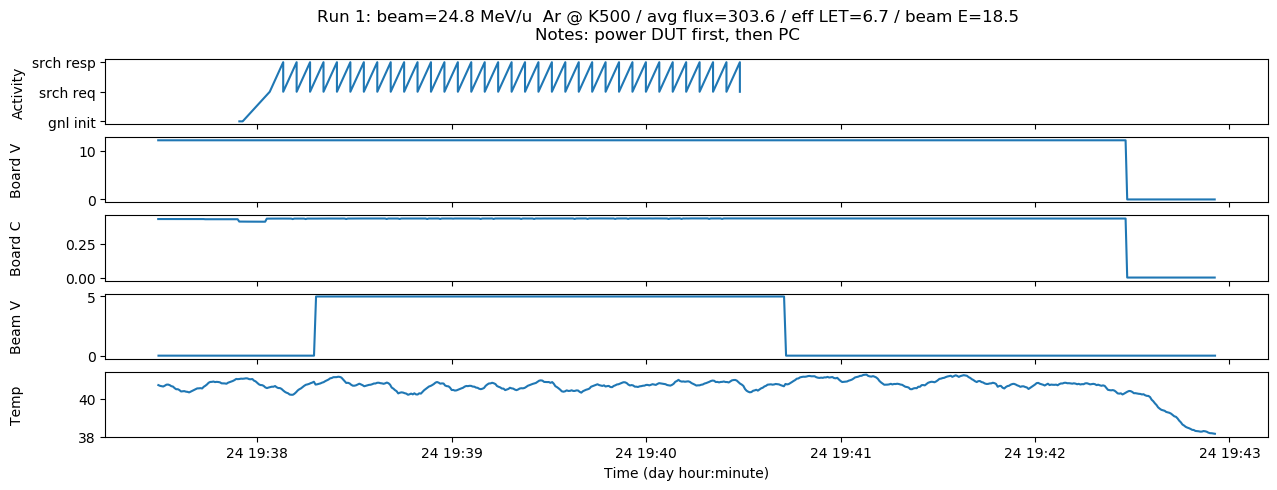

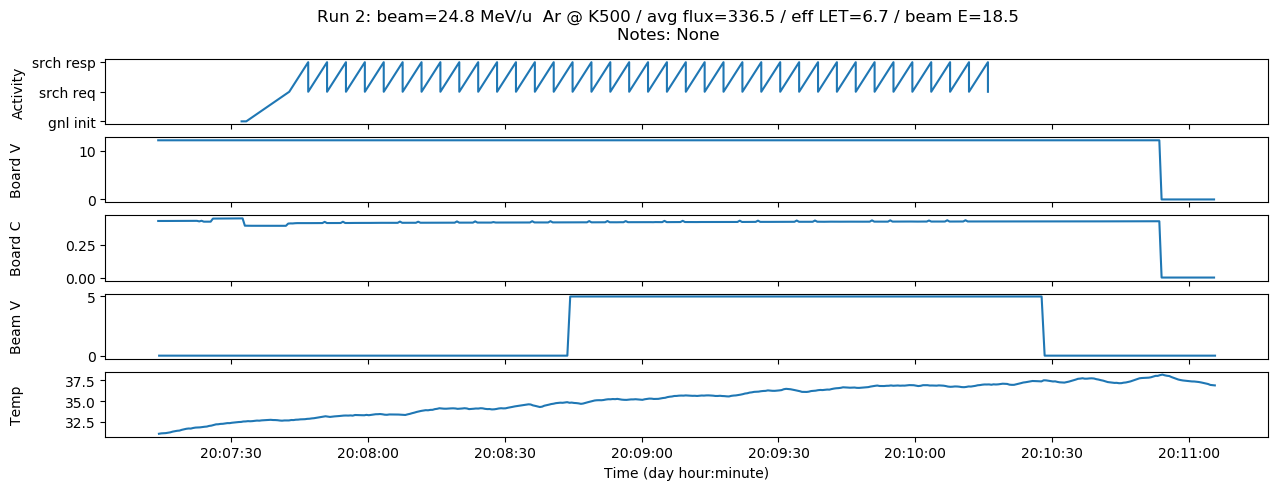

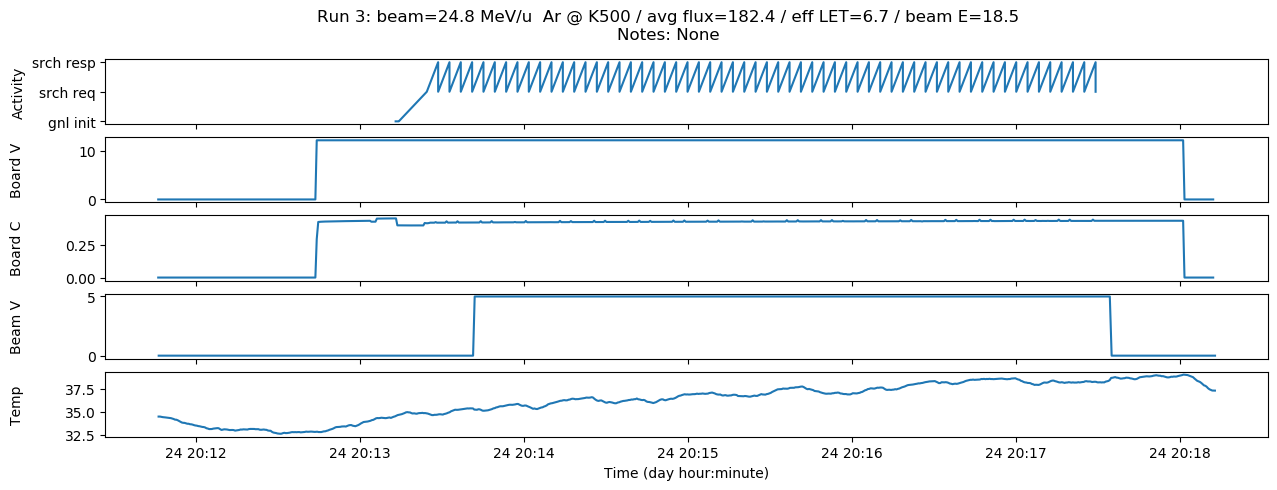

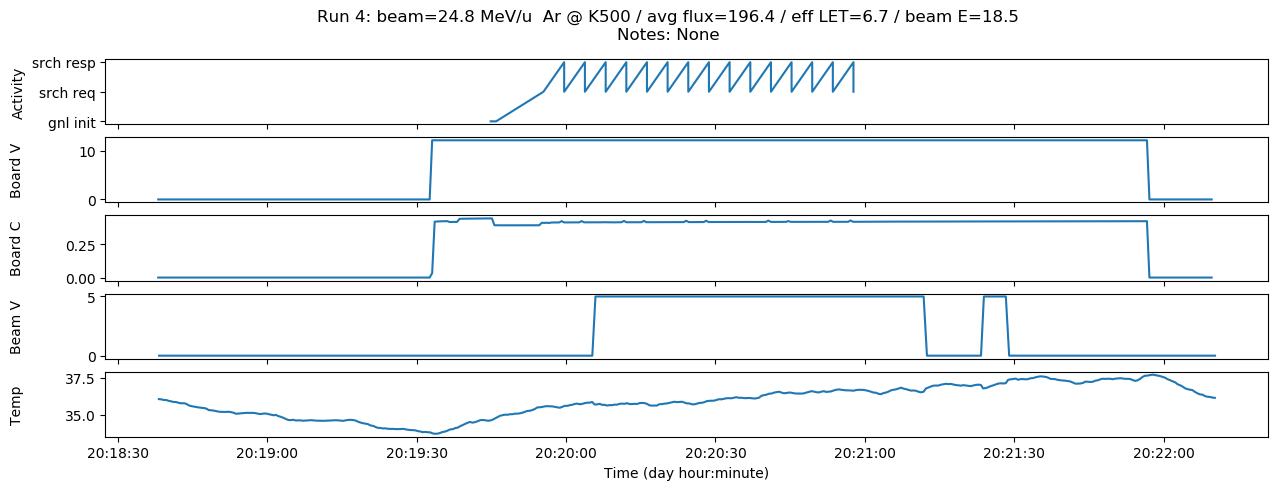

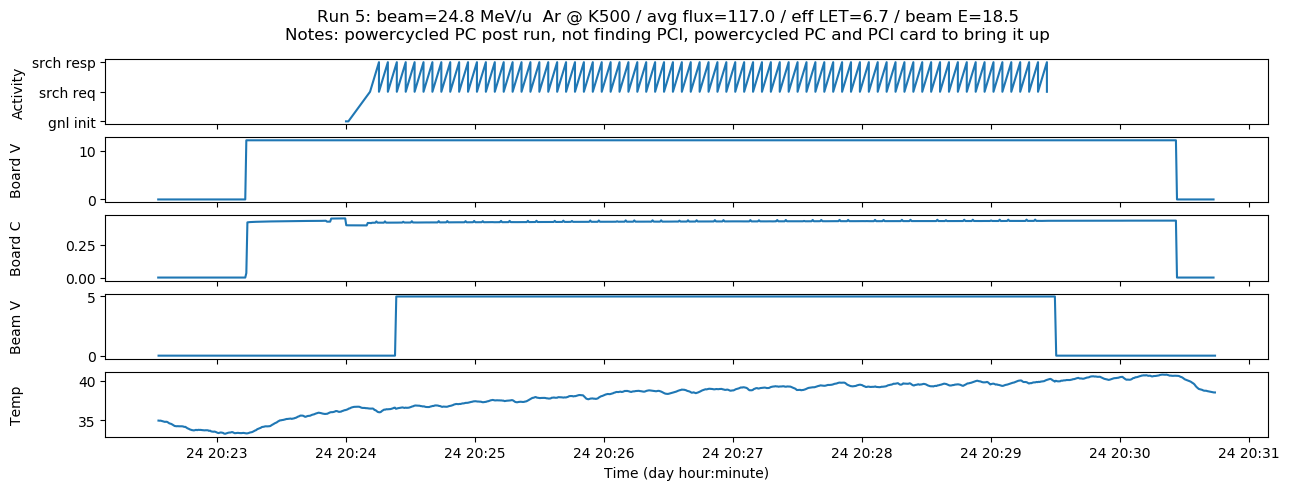

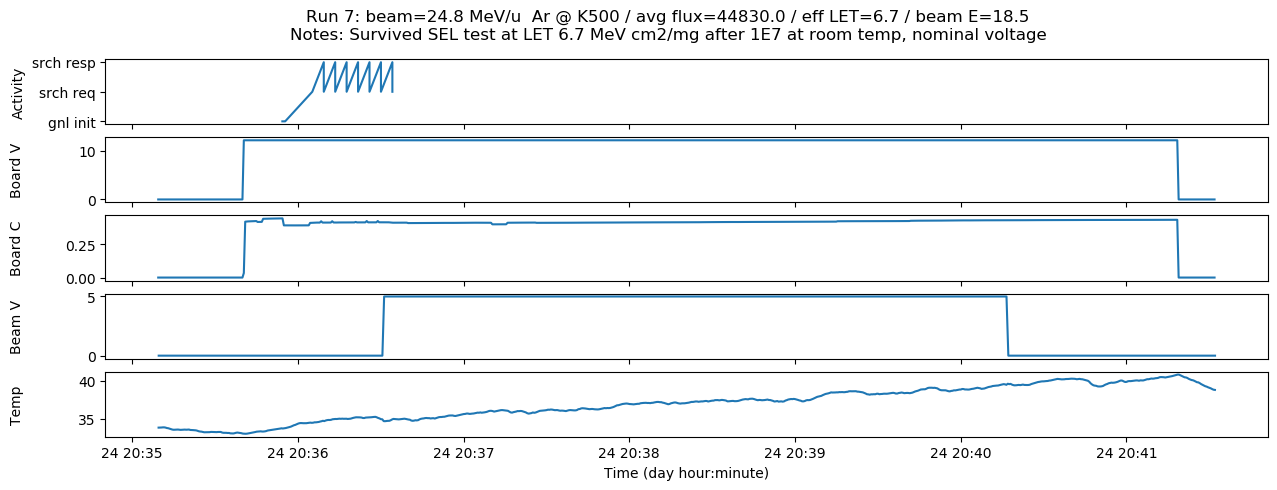

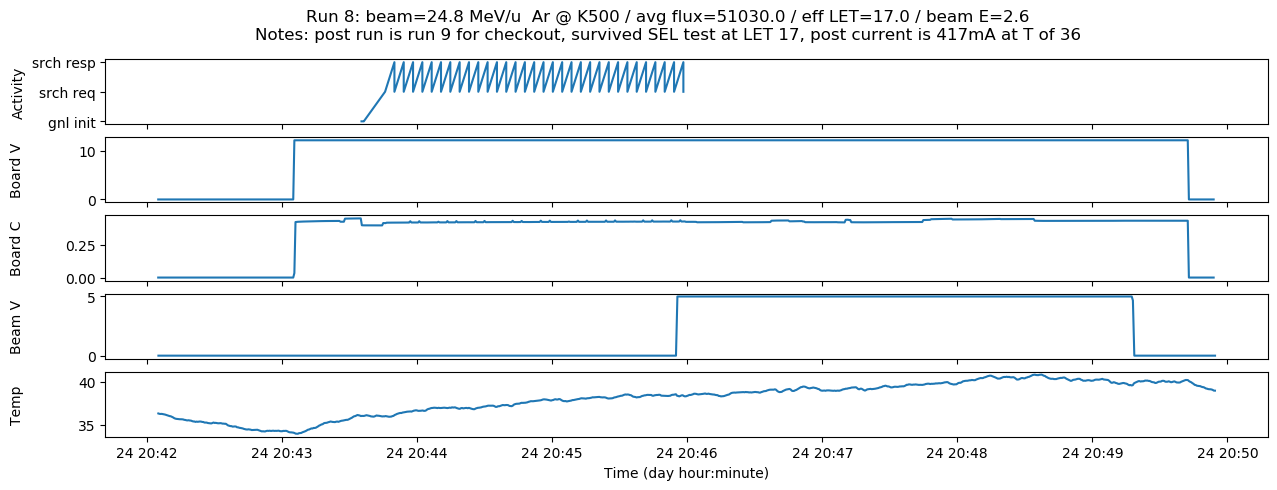

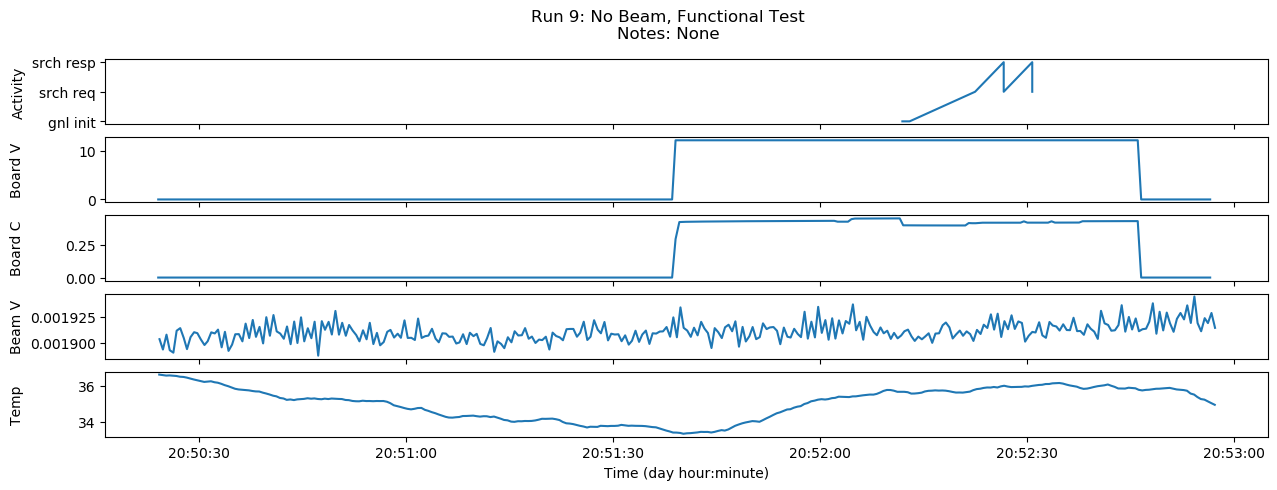

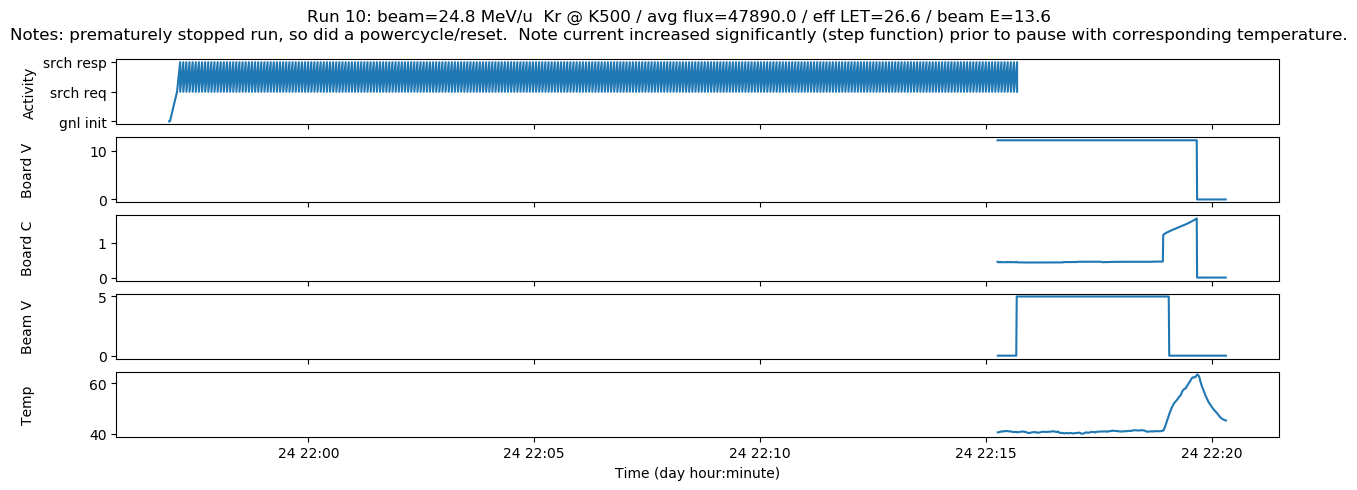

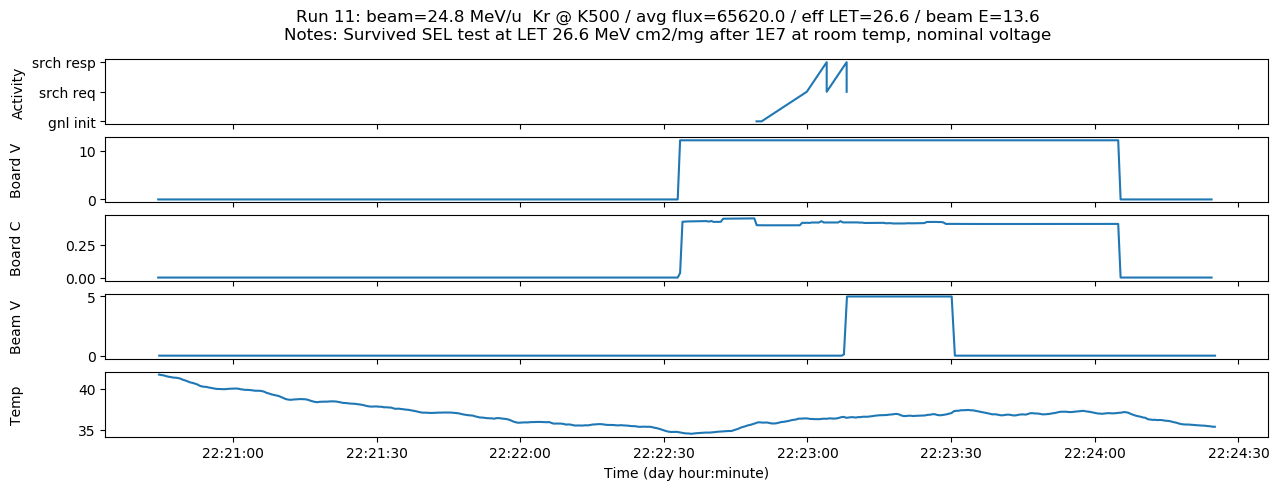

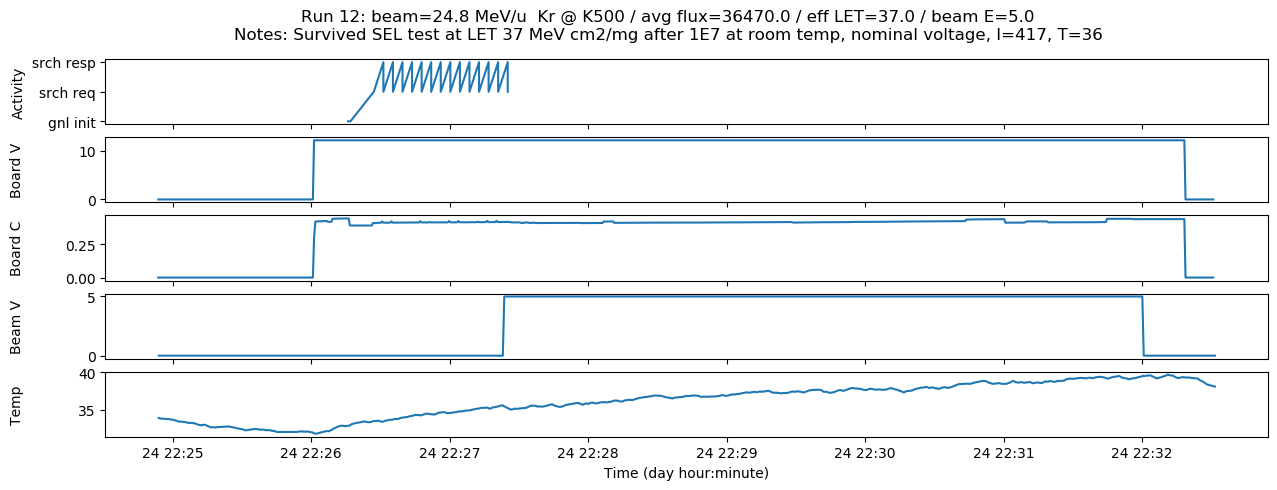

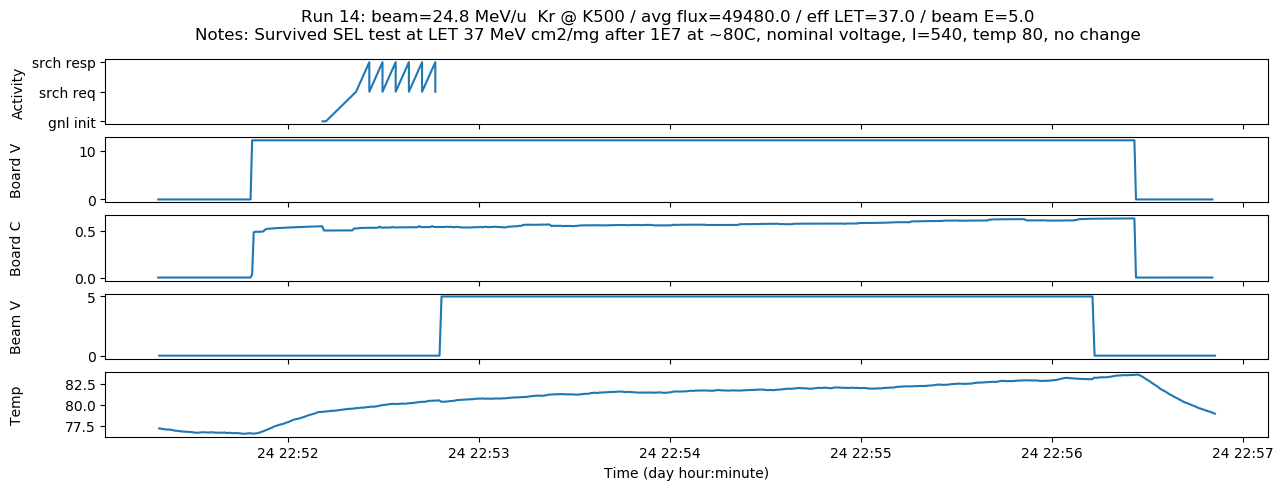

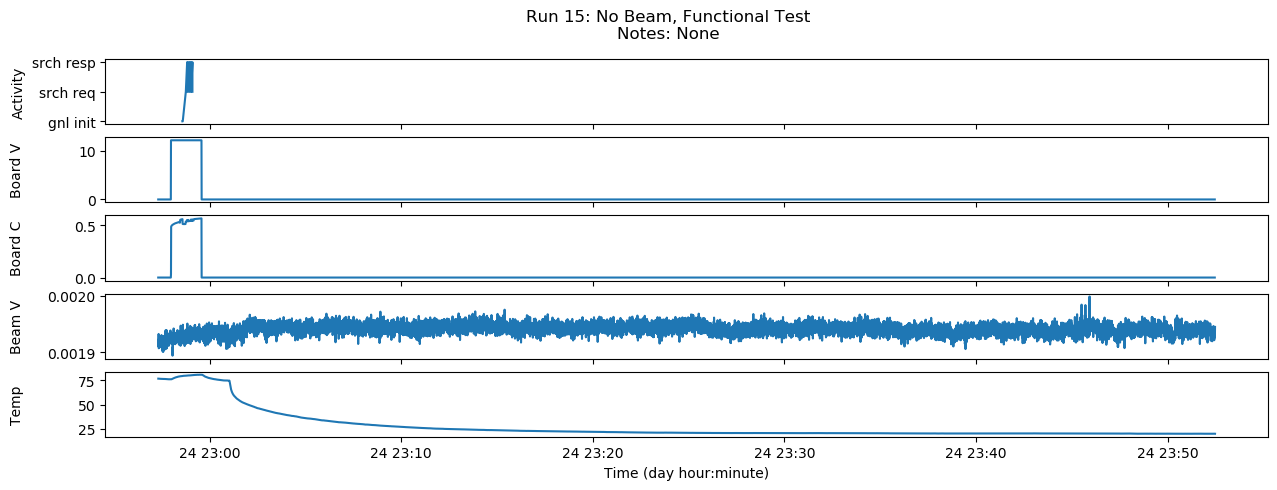

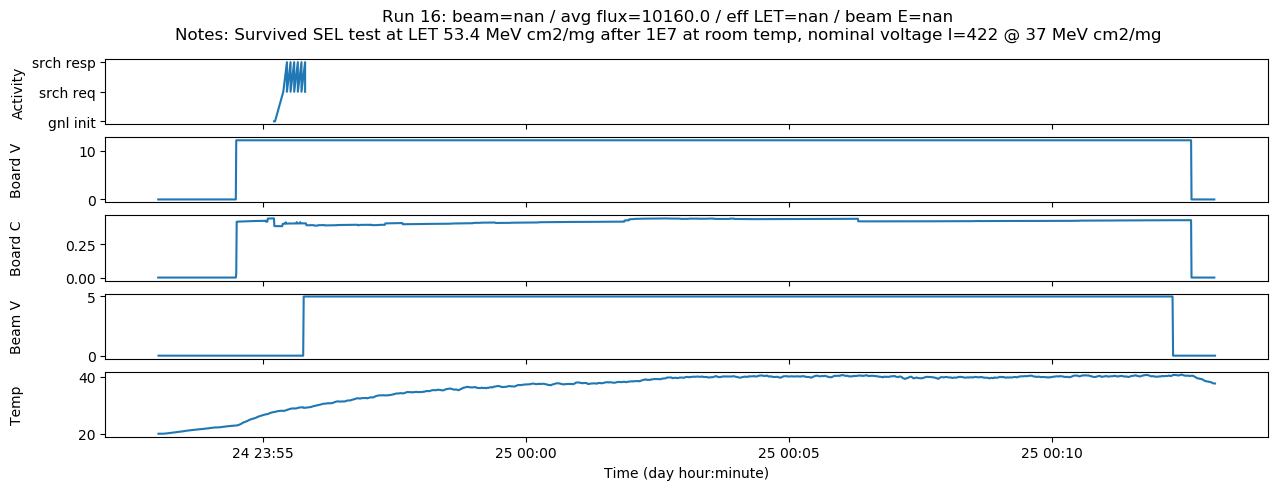

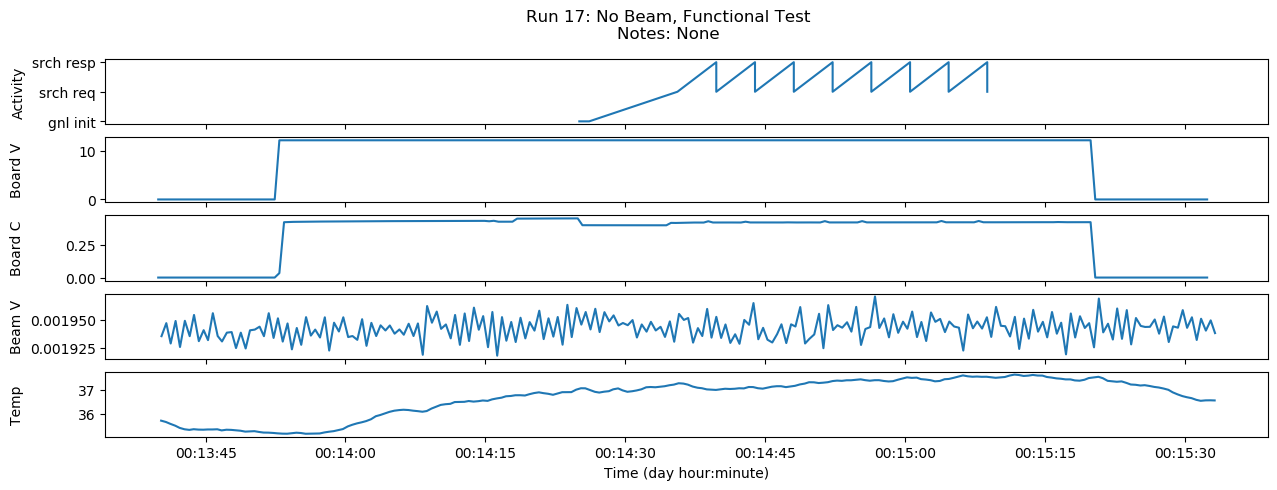

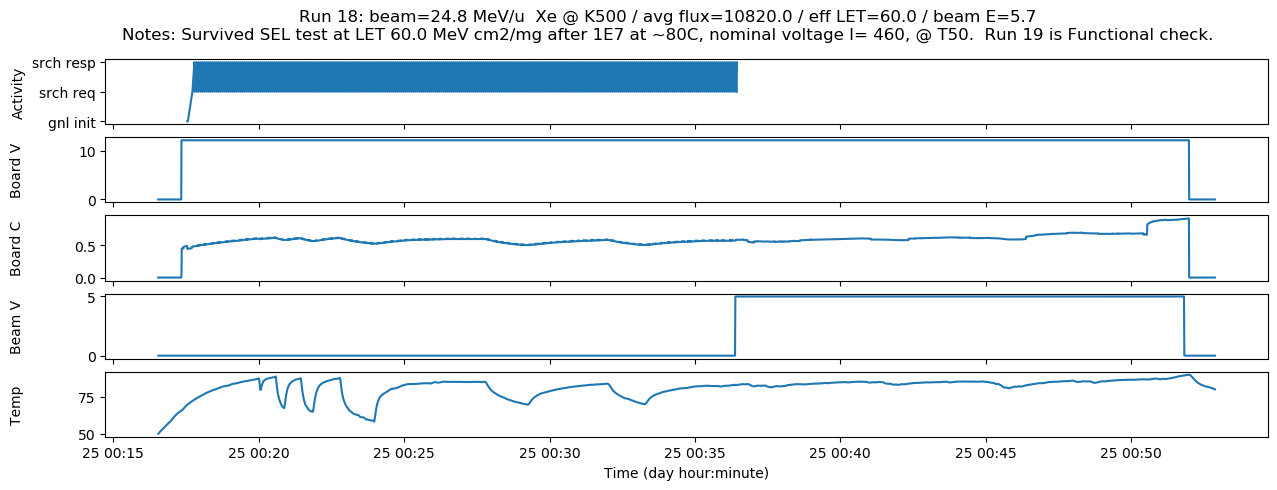

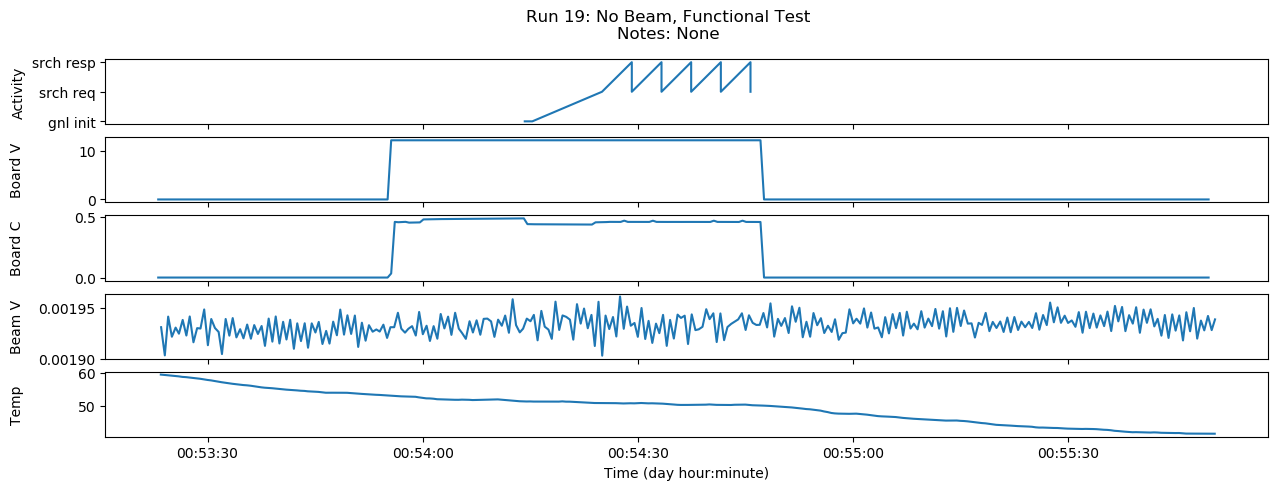

In [83]:
FSIZE = (15,5)


def plot_all( gsi_ts, logs_marker, troxel_ts, voltages, current, \
             troxel_beamvoltages_ts, beam_voltages, troxel_temp_ts, \
             temps, fname, subtitle, notes):
    if (gsi_ts ==None ): return
    
    fig, axes = plt.subplots(5,1, sharex = True, figsize=FSIZE,dpi=100) 
    #print(fig, axes)

    axes[0].set_yticks([-1,0,1])
    axes[0].set_yticklabels(["gnl init","srch req", "srch resp"])

    axes[-1].set_xlabel("Time (day hour:minute)")

    axes[0].set_ylabel("Activity")
    axes[1].set_ylabel("Board V")
    axes[2].set_ylabel("Board C")
    axes[3].set_ylabel("Beam V")
    axes[4].set_ylabel("Temp")

    axes[0].plot(gsi_ts, logs_marker)
    axes[1].plot(troxel_ts, voltages)
    axes[2].plot(troxel_ts, current)
    axes[3].plot(troxel_beamvoltages_ts, beam_voltages)
    axes[4].plot(troxel_temp_ts, temps)

    #10
    #axes[1].yaxis.set_label_coords(-0.103,0.5)
    #axes[2].yaxis.set_label_coords(-0.103,0.5)

    #15
    axes[1].yaxis.set_label_coords(-0.07,0.5)
    axes[2].yaxis.set_label_coords(-0.07,0.5)
    axes[3].yaxis.set_label_coords(-0.07,0.5)
    axes[4].yaxis.set_label_coords(-0.07,0.5)
 
    fig.suptitle("%s\n%s" % ( "%s: %s" % (fname, subtitle), "Notes: %s" % notes))
    fig.savefig("%s.jpg" % fname,dpi=100,quality=100)
    

for i in range(len(all_dirs)):
    gsi_ts = all_gsi_ts[i]
    logs_marker = all_logs_marker[i]
    troxel_ts = all_troxel_ts[i]
    voltages = all_voltages[i]
    current = all_current[i]
    troxel_beamvoltages_ts = all_troxel_beamvoltages_ts[i]
    beam_voltages = all_beam_voltages[i]
    troxel_temp_ts = all_troxel_temp_ts[i]
    temps = all_temps[i]
    fname = all_dirs[i][2]
    
    subtitle = "No Beam, Functional Test"
    if ( (i+1) in expdetails.keys() ):
        subtitle = expdetails[i+1]
        
    notes = "None"
    if ( (i+1) in expnotes.keys() ):
        notes = expnotes[i+1]
    
    try:
        plot_all( gsi_ts, logs_marker, troxel_ts, voltages, current, \
             troxel_beamvoltages_ts, beam_voltages, troxel_temp_ts, \
                 temps, fname, subtitle,notes )
    except:
        print("Could not plot", i)